In [10]:
import os
import torch
import numpy as np
from functools import partial
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from Helper_files.Data_Degradation_Functions import *
from Helper_files.Helper_Functions import input_range_to_random_value
from Dataloader import CustomDataLoader, CustomDataset

class CustomDataset_V2(Dataset):
    def __init__(self, dir_path, store_full_dataset_in_memory=False, bundle_size=1000):
        self.bundle_size = bundle_size
        self.data_dir = dir_path + "/Data/"
        self.file_list = os.listdir(self.data_dir)
        self.load_from_memory = store_full_dataset_in_memory
        if store_full_dataset_in_memory:
            self.load_data_into_memory()

    def load_data_into_memory(self):
        self.data = torch.cat([torch.load(self.data_dir + file_name) for file_name in tqdm(self.file_list, desc="Loading data into memory", leave=False, unit="Sample Bundle (1000 Files)")], dim=0)

    def get_bundle(self, bundle_index):
        self.data_bundle = torch.load(self.data_dir + self.file_list[bundle_index])

    def __getitem__(self, index):         # UPDATE METHOD TO DIRECTLY RETURN BATCHES?????
        if self.load_from_memory:
            sample = self.data[index]

        else:
            sample_bundle_index = index // self.bundle_size
            sample_index_in_bundle = index % self.bundle_size

            # call load bundle function if index is 0 or a multiple of bundle_size
            if sample_index_in_bundle == 0:
                self.get_bundle(sample_bundle_index)

            # load sample from bundle
            sample = self.data_bundle[sample_index_in_bundle]                                           

        return sample
    
    def __len__(self):
        return len(self.file_list) * self.bundle_size

class CustomDataLoader_V2(DataLoader):
    def __init__(self, input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision, *args, **kwargs):
        super(CustomDataLoader_V2, self).__init__(*args, **kwargs)
        self.input_signal_settings = input_signal_settings
        self.physical_scale_parameters = physical_scale_parameters
        self.time_dimension = time_dimension
        self.device = device
        self.preprocess_on_gpu = preprocess_on_gpu
        self.precision = precision
        
        
    def __iter__(self):
        return CustomDataLoaderIter_V2(self, self.input_signal_settings, self.physical_scale_parameters, self.time_dimension, self.device, self.preprocess_on_gpu, self.precision)

class CustomDataLoaderIter_V2:
    def __init__(self, loader, input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision):
        self.loader = loader
        self.collate_fn = loader.collate_fn
        self.batch_sampler = loader.batch_sampler
        self.dataset = loader.dataset
        self.index_generator = loader._get_iterator()
        self.sample_iter = iter(self.batch_sampler)
        self.input_signal_settings = input_signal_settings
        self.physical_scale_parameters = physical_scale_parameters
        self.time_dimension = time_dimension
        self.set_dtype(precision)
        self.preprocess_on_gpu = preprocess_on_gpu
        if self.preprocess_on_gpu:
            self.device = device
        else:
            self.device = torch.device("cpu")
    
    def set_dtype(self, precision):
        if precision == 16:
            self.dtype = torch.float16
        elif precision == 32:
            self.dtype = torch.float32
        elif precision == 64:
            self.dtype = torch.float64
        else:
            raise ValueError("Invalid dataloader 'precision' value selected. Please select 16, 32, or 64 which correspond to torch.float16, torch.float32, and torch.float64 respectively.")      
          

    def _custom_processing(self, batch):
        signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points = self.input_signal_settings  # move directly into next line without breaking out?
        signal_settings = input_range_to_random_value(signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points) 
        degraded_batches = signal_degredation(signal_settings, batch, self.physical_scale_parameters, self.time_dimension, self.device)
        return degraded_batches   

    def __iter__(self):
        return self

    def __next__(self):
        indices = next(self.sample_iter)
        batch = self.collate_fn([self.dataset[i] for i in indices])
        batch = batch.to(self.dtype)
        batch = batch.to(self.device)

        sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch = self._custom_processing(batch)

        return batch, sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch


# # Test the custom dataset class
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from torchvision import transforms
    from torch.utils.data import DataLoader

    time_dimension = 100
    physical_scale_parameters = [0.1, 0.1, 0.1]

    preprocess_on_gpu = True   # Only woirks if cuda gpu is found, else will defulat back to cpu preprocess
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    store_full_dataset_in_memory = True
    precision = 32
    batch_size = 1000
    signal_points = 150 
    noise_points = 20
    x_std_dev = 0
    y_std_dev = 0
    tof_std_dev = 0
    input_signal_settings = [signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points]

    # Create dataset
    #dataset = CustomDataset("N:\Yr 3 Project Datasets\RDT 50KM Fix", precision, store_full_dataset_in_memory)
    #dataset2 = CustomDataset_V2("N:\Yr 3 Project Datasets\[V2]RDT 50KM Fix", store_full_dataset_in_memory)

    # Create dataloader
    #dataloader = CustomDataLoader(input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision, dataset, batch_size, shuffle=False, num_workers=0)
    #dataloader2 = CustomDataLoader_V2(input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision, dataset2, batch_size, shuffle=False, num_workers=0)


  

In [11]:

time_dimension = 100
physical_scale_parameters = [0.1, 0.1, 0.1]

preprocess_on_gpu = True   # Only woirks if cuda gpu is found, else will defulat back to cpu preprocess
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
store_full_dataset_in_memory = False
precision = 32
batch_size = 100
signal_points = 5550 
noise_points = 0
x_std_dev = 0
y_std_dev = 0
tof_std_dev = 0
input_signal_settings = [signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points]

# Create dataset
dataset = CustomDataset("N:\Yr 3 Project Datasets\RDT 50KM Fix", precision, store_full_dataset_in_memory)
dataset2 = CustomDataset_V2("N:\Yr 3 Project Datasets\[V2]RDT 50KM Fix", store_full_dataset_in_memory)

# Create dataloader
dataloader = CustomDataLoader(input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision, dataset, batch_size, shuffle=False, num_workers=0)
dataloader2 = CustomDataLoader_V2(input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision, dataset2, batch_size, shuffle=False, num_workers=0)


def run_test(dataloader):
    for sample_batch in tqdm(dataloader):
        pass
    print("Finished")



In [12]:
# Get a batch of data
i = 0
for sample_batched1, sample_batched2 in zip(dataloader, dataloader2):
    i = i + 1
    print(torch.allclose(sample_batched1[0], sample_batched2[0]))
    #plt.imshow(sample_batched1[0][0][0].cpu().numpy())
    #plt.show()
    #plt.imshow(sample_batched2[0][0][0].cpu().numpy())
    #plt.show()
    if i == 10:
        break
print("Finished")


True
True
True
True
True
True
True
True
True
True
Finished


In [13]:

import timeit

In [14]:

import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
import torch
import os

# Dummy dataset class
class DTM_Dataset(Dataset):
    """
    Disk to Memory Dataset
    Loads data from disk to memory in the form of bundles to reduce i/o operations

    Args:
    data_dir: str, the directory where the data files are stored

    Methods:
    __len__: returns the number of data files

    __getitem__: returns a data file
    
    """
    def __init__(self, data_dir):
        # Get all .npy files in the specified directory
        self.data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.pt')]
        self.size = len(self.data_files)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data = torch.load(self.data_files[idx])
        return data
    
class MTN_Dataset(Dataset):
    """
    Memory to Network Dataset
    Loads data from memory to the neural network in the form of individual samples, handling shuffling across the two datasets and iteration bewteen them

    Args:
    large_data_bundles_size: int, the number of individual files in each bundle
    large_batch_size: int, the number of bundles to load into memory at once
    shuffle_data: bool, whether to shuffle the data across both large and small batches

    Methods:
    __len__: returns the number of individual samples in the entire dataset of bundles

    __getitem__: returns a single sample from memory
    """

    def __init__(self, dataset_path_ondisk, large_data_bundles_size=4, large_batch_size=1, shuffle_data=False, dtype=torch.float32):
        self.large_dataset = DTM_Dataset(dataset_path_ondisk)
        self.large_dataloader = DataLoader(self.large_dataset, large_batch_size, shuffle_data)
        self.large_data_bundles_size = large_data_bundles_size
        self.large_batch_size = large_batch_size
        self.indices = list(range(self.large_data_bundles_size * self.large_batch_size))
        self.shuffle_data = shuffle_data
        self.dtype = dtype

    def __len__(self):
        return len(self.large_dataset) * self.large_data_bundles_size
    
    def __getitem__(self, idx):
        if idx == 0:
            self.large_dataloader_iterator = iter(self.large_dataloader) # Restarts the large/DTM dataloader iterator

        if idx % (self.large_data_bundles_size * self.large_batch_size) == 0: # If the index is a multiple of the bundle size then load a new bundle of data into memory
            # Load a new bundle of data
            self.data = next(self.large_dataloader_iterator)

            # Shuffling across the bundle, without loosing the ability to use logic based on index
            self.shuffled_indices = self.indices.copy()
            if self.shuffle_data:
                random.shuffle(self.shuffled_indices)

        internal_bundle_idx = self.shuffled_indices[idx % (self.large_data_bundles_size * self.large_batch_size)] # Get the index of the data in the bundle

        return self.data[internal_bundle_idx // self.large_data_bundles_size, internal_bundle_idx % self.large_data_bundles_size] 
    
class StackedDatasetLoader(DataLoader):
    """
    Very simple datalaoder with one additional function that perfroms a preprocessing step on the data before returning it to the neural network

    """

    def __init__(self, input_signal_settings, physical_scale_parameters, time_dimension, device, *args, pre_process_data=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.pre_process_data = pre_process_data
        self.input_signal_settings = input_signal_settings
        self.physical_scale_parameters = physical_scale_parameters
        self.time_dimension = time_dimension
        self.device = device
        self.dtype = torch.float32
    
    def _custom_processing(self, batch):
        signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points = self.input_signal_settings  # move directly into next line without breaking out?
        signal_settings = input_range_to_random_value(signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points) 
        degraded_batches = signal_degredation(signal_settings, batch, self.physical_scale_parameters, self.time_dimension, self.device)
        return degraded_batches   

    def __iter__(self):
        for batch in super().__iter__():
            batch = batch.to(self.dtype)
            degraded_data = self._custom_processing(batch)
            sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch = degraded_data
            yield batch, sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch


dataset_path_ondisk = r'N:\Yr 3 Project Datasets\[V2]RDT 50KM Fix\Data\\'    # Path to the directory where the data files are stored on disk in bundles
large_data_bundles_size = 1000     # the number of individual files in each bundle
number_of_bundles_to_memory = 1 # Essentially the 'Large batch Size' i.e how many bundles to load into memory at once [Must be less than or equal to the number of bundles in the dataset on disk]
small_batch_size = 100            # Batch Size for loading into the neural net from the in memory bundles               
shuffle_data = False             # Shuffle the data across both large and small batches

small_dataset = MTN_Dataset(dataset_path_ondisk, large_data_bundles_size, number_of_bundles_to_memory, shuffle_data)
small_dataloader = StackedDatasetLoader(input_signal_settings, physical_scale_parameters, time_dimension, device, dataset=small_dataset, batch_size=small_batch_size, pre_process_data=True) # Shuffle is handled by the dataset, set with the variable 'shuffle_data'. It must not be applied here otherwise will induce errors in the logic based on index value

for idx, data in enumerate(small_dataloader):
    batch, sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch = data
    print(f"idx {idx} shhape: {batch.shape}")

    if idx == 1:
        break


idx 0 shhape: torch.Size([100, 1, 128, 88])
idx 1 shhape: torch.Size([100, 1, 128, 88])


Batch shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_batch_shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_and_resolution_limited_batch torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
noised_sparse_reslimited_batch torch.Size([100, 1, 128, 88])   
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)


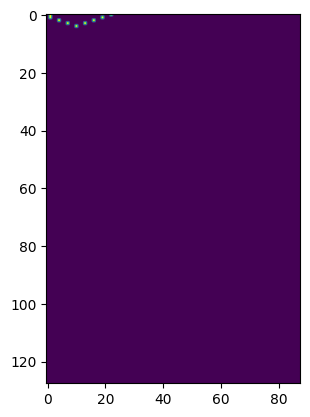

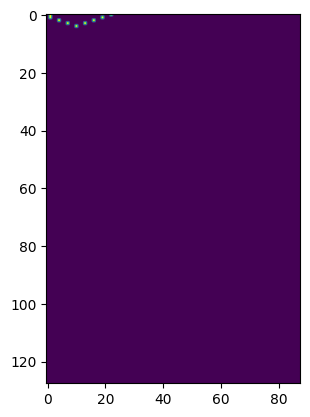

Batch shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_batch_shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_and_resolution_limited_batch torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
noised_sparse_reslimited_batch torch.Size([100, 1, 128, 88])   
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)


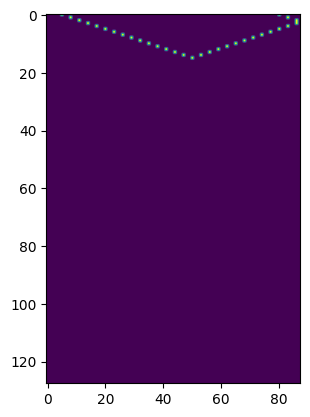

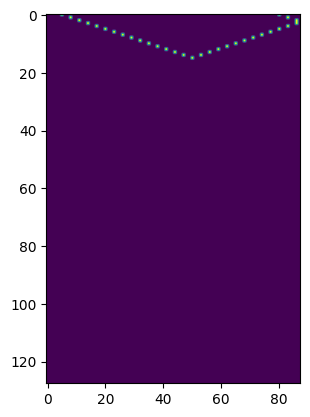

Batch shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_batch_shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_and_resolution_limited_batch torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
noised_sparse_reslimited_batch torch.Size([100, 1, 128, 88])   
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)


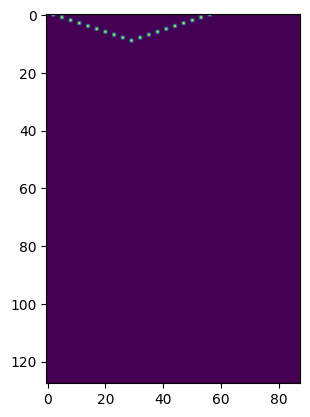

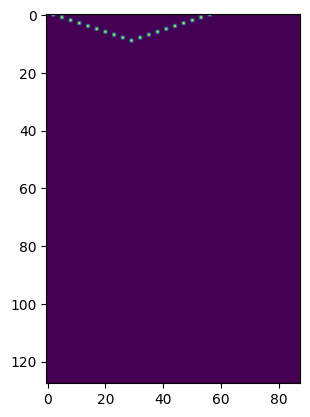

Batch shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_batch_shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_and_resolution_limited_batch torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
noised_sparse_reslimited_batch torch.Size([100, 1, 128, 88])   
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)


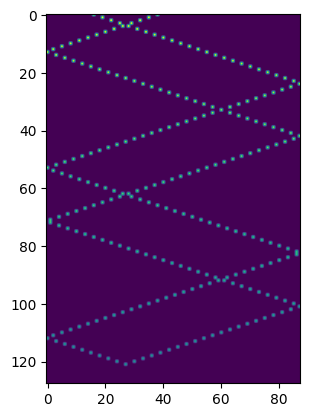

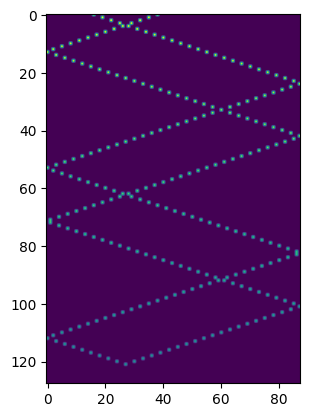

Batch shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_batch_shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_and_resolution_limited_batch torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
noised_sparse_reslimited_batch torch.Size([100, 1, 128, 88])   
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)


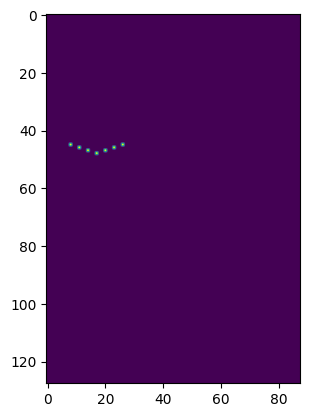

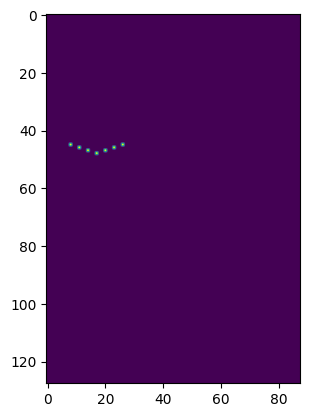

Batch shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_batch_shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_and_resolution_limited_batch torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
noised_sparse_reslimited_batch torch.Size([100, 1, 128, 88])   
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)


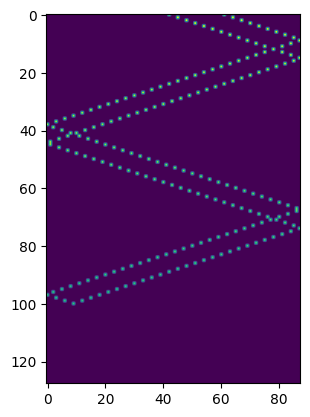

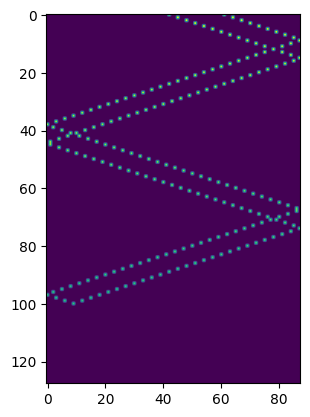

Batch shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_batch_shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_and_resolution_limited_batch torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
noised_sparse_reslimited_batch torch.Size([100, 1, 128, 88])   
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)


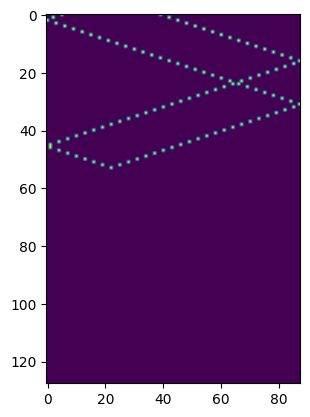

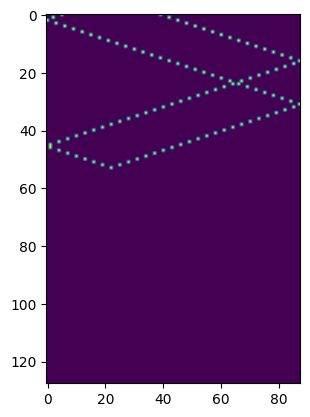

Batch shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_batch_shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_and_resolution_limited_batch torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
noised_sparse_reslimited_batch torch.Size([100, 1, 128, 88])   
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)


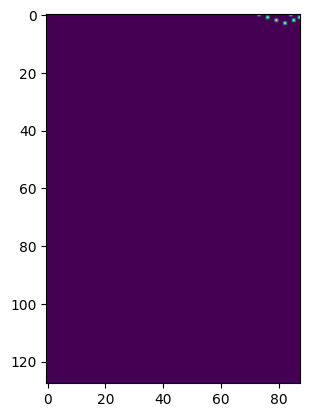

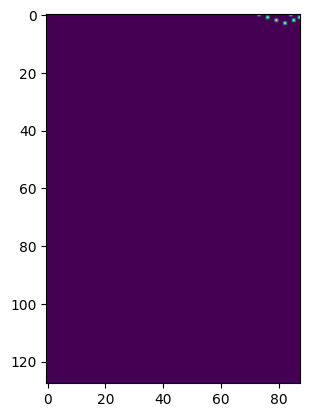

Batch shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_batch_shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_and_resolution_limited_batch torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
noised_sparse_reslimited_batch torch.Size([100, 1, 128, 88])   
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)


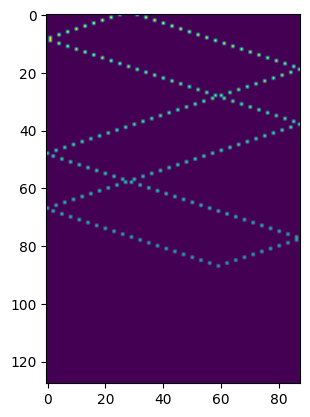

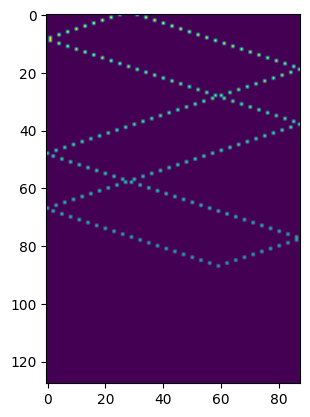

Batch shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_batch_shape torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
sparse_and_resolution_limited_batch torch.Size([100, 1, 128, 88])
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)
noised_sparse_reslimited_batch torch.Size([100, 1, 128, 88])   
[ True  True  True  True]
True
min value:  tensor(0.)
max value:  tensor(999.)
min value 2:  tensor(0.)
max value 2:  tensor(999.)


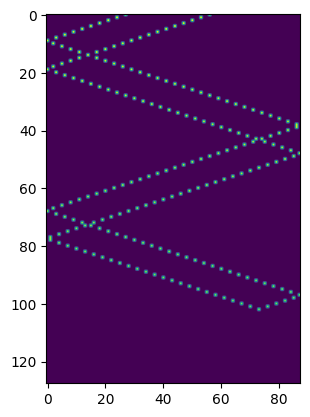

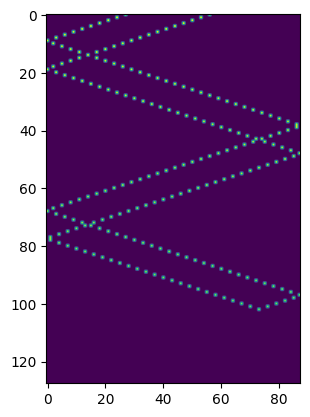

Finished


In [15]:
# Get a batch of data
i = 0
for sample_batched1, sample_batched2 in zip(dataloader2, small_dataloader):

    batch, sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch = sample_batched1
    batch_2, sparse_output_batch_2, sparse_and_resolution_limited_batch_2, noised_sparse_reslimited_batch_2 = sample_batched2
    
    print(f"Batch shape {batch.shape}")
    print(np.isclose(batch.shape, batch_2.shape))
    print(torch.allclose(batch, batch_2))
    print("min value: ", torch.min(batch))  
    print("max value: ", torch.max(batch))
    print("min value 2: ", torch.min(batch_2))
    print("max value 2: ", torch.max(batch_2))

    print(f"sparse_batch_shape {sparse_output_batch.shape}")
    print(np.isclose(sparse_output_batch.shape, sparse_output_batch_2.shape))
    print(torch.allclose(sparse_output_batch, sparse_output_batch_2))
    print("min value: ", torch.min(sparse_output_batch))
    print("max value: ", torch.max(sparse_output_batch))
    print("min value 2: ", torch.min(sparse_output_batch_2))
    print("max value 2: ", torch.max(sparse_output_batch_2))


    print(f"sparse_and_resolution_limited_batch {sparse_and_resolution_limited_batch.shape}")
    print(np.isclose(sparse_and_resolution_limited_batch.shape, sparse_and_resolution_limited_batch_2.shape))
    print(torch.allclose(sparse_and_resolution_limited_batch, sparse_and_resolution_limited_batch_2))
    print("min value: ", torch.min(sparse_and_resolution_limited_batch))
    print("max value: ", torch.max(sparse_and_resolution_limited_batch))
    print("min value 2: ", torch.min(sparse_and_resolution_limited_batch_2))
    print("max value 2: ", torch.max(sparse_and_resolution_limited_batch_2))


    print(f"noised_sparse_reslimited_batch {noised_sparse_reslimited_batch.shape}   ")
    print(np.isclose(noised_sparse_reslimited_batch.shape, noised_sparse_reslimited_batch_2.shape))
    print(torch.allclose(noised_sparse_reslimited_batch, noised_sparse_reslimited_batch_2))
    print("min value: ", torch.min(noised_sparse_reslimited_batch)) 
    print("max value: ", torch.max(noised_sparse_reslimited_batch))
    print("min value 2: ", torch.min(noised_sparse_reslimited_batch_2))
    print("max value 2: ", torch.max(noised_sparse_reslimited_batch_2))


    i = i + 1
    #print(torch.allclose(sample_batched1[0], sample_batched2[0]))
    
    plt.imshow(sparse_and_resolution_limited_batch[0][0].cpu().numpy())
    plt.show()
    plt.imshow(sparse_and_resolution_limited_batch_2[0][0].cpu().numpy())
    plt.show()
    if i == 10:
        break
print("Finished")

In [16]:
import timeit

# Measure the execution time for dataloader
#time_taken_dataloader = timeit.timeit('run_test(dataloader)', globals=globals(), number=1)

# Measure the execution time for dataloader2
#time_taken_dataloader2 = timeit.timeit('run_test(dataloader2)', globals=globals(), number=1)

time_taken_datloader3 = timeit.timeit('run_test(small_dataloader)', globals=globals(), number=1)

#print(f"Time taken for dataloader: {time_taken_dataloader} seconds")
#print(f"Time taken for dataloader2: {time_taken_dataloader2} seconds")
print(f"Time taken for dataloader3: {time_taken_datloader3} seconds")

 24%|██▍       | 119/500 [00:22<01:12,  5.26it/s]


KeyboardInterrupt: 